In [4]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from matplotlib import rcParams

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

from auriga_basics import *
%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'

cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [7]:
machine = 'virgo'
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
    


In [10]:
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"
level = 4
#### action time evolution
startnr = 73
endnr = 128
xrange = np.arange(startnr, endnr, 1)
lookback_time_Gyr = []
jR_mean = []
jR_std = []
jz_mean = []
jz_std = []
lz_mean = []
lz_std = []
jR_all = []
jz_all = []
lz_all = []
hist_x = []
histtime_x = []
for snap_number in range(startnr, endnr, 1):
    print(snap_number)
    s, sf = eat_snap_and_fof(level, halo_number, snap_number, snappath, loadonlytype=[4], 
        haloid=0, galradfac=0.1, verbose=False, rotate_disk=0, use_principal_axis=0, euler_rotation=0, use_cold_gas_spin=0, do_rotation=0) 

    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    #s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 ) 

    snap_time = s.cosmology_get_lookback_time_from_a( s.time, is_flat=True )
    lookback_time_Gyr.append(snap_time)
    infile = filedir + 'actions_merger_73_2648_parts_snap_' +str(snap_number)+ '_nonsmoothed_pot_params.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)


    jR_hist = np.histogram(jR_kpckms, bins = 20, range = (0., 15000.))
    jz_hist = np.histogram(jz_kpckms, bins = 20, range = (0., 5000.))
    lz_hist = np.histogram(lz_kpckms, bins = 20, range = (-10000., 10000.))
#cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))    
    jR_mean.append(np.mean(jR_kpckms)) 
    jR_std.append(np.std(jR_kpckms))
    jz_mean.append(np.mean(jz_kpckms)) 
    jz_std.append(np.std(jz_kpckms))
    lz_mean.append(np.mean(lz_kpckms)) 
    lz_std.append(np.std(lz_kpckms))
    jR_all.append(jR_kpckms)
    jz_all.append(jz_kpckms)
    lz_all.append(lz_kpckms)
    #np.loadtxt('actions_snap_' + str(snap_number) + '_nonsmoothed_pot_params.txt
    hist_x.append(np.full(len(jR_kpckms), snap_number))
    histtime_x.append(np.full(len(jR_kpckms), snap_time))

73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [11]:
flat_jR = [item for sublist in jR_all for item in sublist]
flat_jz = [item for sublist in jz_all for item in sublist]
flat_lz = [item for sublist in lz_all for item in sublist]
flat_histx = [item for sublist in hist_x for item in sublist]
flat_histtime = [item for sublist in histtime_x for item in sublist]

In [98]:
from matplotlib 

55

In [12]:
flat_jR = np.array(flat_jR)
flat_jz = np.array(flat_jz)
flat_lz = np.array(flat_lz)
flat_histx = np.array(flat_histx)
flat_histtime = np.array(flat_histtime)

In [17]:
xrange = np.arange(startnr, endnr, 1)
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,15))

ax[0].hist2d(flat_histx[flat_jR <15000.], flat_jR[flat_jR < 15000.], bins = 55, cmap = plt.cm.binary)

#ax[0].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
ax[0].plot(xrange, jR_mean, 'r-')
ax[0].plot(xrange, np.add(jR_mean, jR_std), '-', alpha = 0.5,  color = 'lightred')
ax[0].plot(xrange, np.subtract(jR_mean, jR_std), '-', alpha = 0.5,  color = 'lightred')

ax[1].hist2d(flat_histx[(flat_lz <5000.) * (flat_lz > -5000.)], flat_lz[(flat_lz <5000.) * (flat_lz > -5000.)], bins = 55, cmap = plt.cm.binary)
ax[1].plot(xrange, lz_mean, 'r-')
ax[1].plot(xrange, np.add(lz_mean, lz_std), '-', alpha = 0.5, color = 'lightred')
ax[1].plot(xrange, np.subtract(lz_mean, lz_std), '-', alpha = 0.5,  color = 'lightred')
#ax[1].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))

ax[2].hist2d(flat_histx[flat_jz <4000.], flat_jz[flat_jz < 4000.], bins = 55, cmap = plt.cm.binary)
ax[2].plot(xrange, jz_mean, 'r-')
ax[2].plot(xrange, np.add(jz_mean, jz_std), '-', alpha = 0.5,  color = 'lightred')
ax[2].plot(xrange, np.subtract(jz_mean, jz_std), '-', alpha = 0.5,  color = 'lightred')
#ax[2].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))

ax[0].set_ylabel('jR [kpc km/s]', fontsize = 20)
ax[1].set_ylabel('lz [kpc km/s]', fontsize = 20)
ax[2].set_ylabel('jz [kpc km/s]', fontsize = 20)
ax[2].set_xlabel('Snapshot number', fontsize = 20)
#ax[2].set_xlabel('lookback time [Gyr]')
fig.tight_layout()
#fig.savefig(plotdir + 'action_time_evolution_hist_mean.png', format = 'png', dpi = 300)
plt.show()

ValueError: Invalid RGBA argument: 'lightred'

In [7]:
bins_jR, xedges_jR, binnum_jR = stats.binned_statistic_dd(jR_all, 1, statistic = 'count')#, bins=2)#,range=[[xmin,xmax],[ymin,ymax]])
plt.imshow(bins, origin='lower', aspect='equal', extent=[xb[0], xb[-1]],)

ValueError: operands could not be broadcast together with shapes (20,) (21,) 

In [14]:
print(lookback_time_Gyr)

[8.6990211581636299, 8.5252475597271111, 8.3825520997474072, 8.2365443853971616, 8.0871857752488765, 7.8957200166374646, 7.7386922627471932, 7.6186521309154633, 7.4555500192211301, 7.2889401605723494, 7.1187996256302029, 6.9888652156874338, 6.8125004792532939, 6.6778802165313964, 6.495248977626658, 6.3559182588176908, 6.1669974933569689, 6.0229465593882683, 5.8768735073487273, 5.7287806295844996, 5.5281878275013261, 5.3753980216321411, 5.2206051600454408, 5.0638170290850022, 4.9050426845407005, 4.744292444640525, 4.5815778793696653, 4.4169117961172937, 4.25030822167591, 4.0817823806421902, 3.9683719440695908, 3.7966793300503907, 3.6231107024105715, 3.4476854370571401, 3.2704239621028588, 3.1512400764782584, 2.9709663781604099, 2.7889157772067175, 2.6665733211784164, 2.4816148011082095, 2.2949450295802403, 2.1695606612398457, 1.9800970740728014, 1.8528750849174935, 1.6606932445711653, 1.4669178894426511, 1.3368632001238121, 1.1404960591271716, 1.008740630401181, 0.80986355178559311, 0.6

In [ ]:
np.add(jR_mean, jR_std)

(8.6990211581636299, 2.5673723560210484e-15)

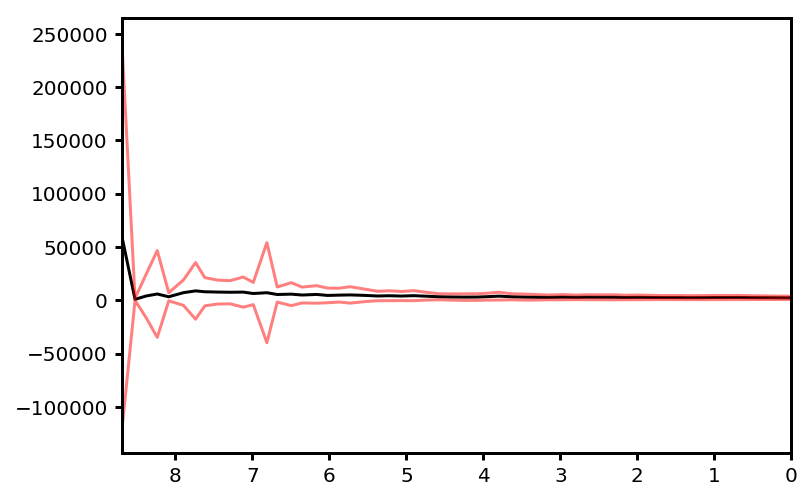

In [15]:
plt.plot(lookback_time_Gyr, jR_mean, 'k-')
plt.plot(lookback_time_Gyr, np.add(jR_mean, jR_std), 'r-', alpha = 0.5)
plt.plot(lookback_time_Gyr, np.subtract(jR_mean, jR_std), 'r-', alpha = 0.5)
plt.xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))


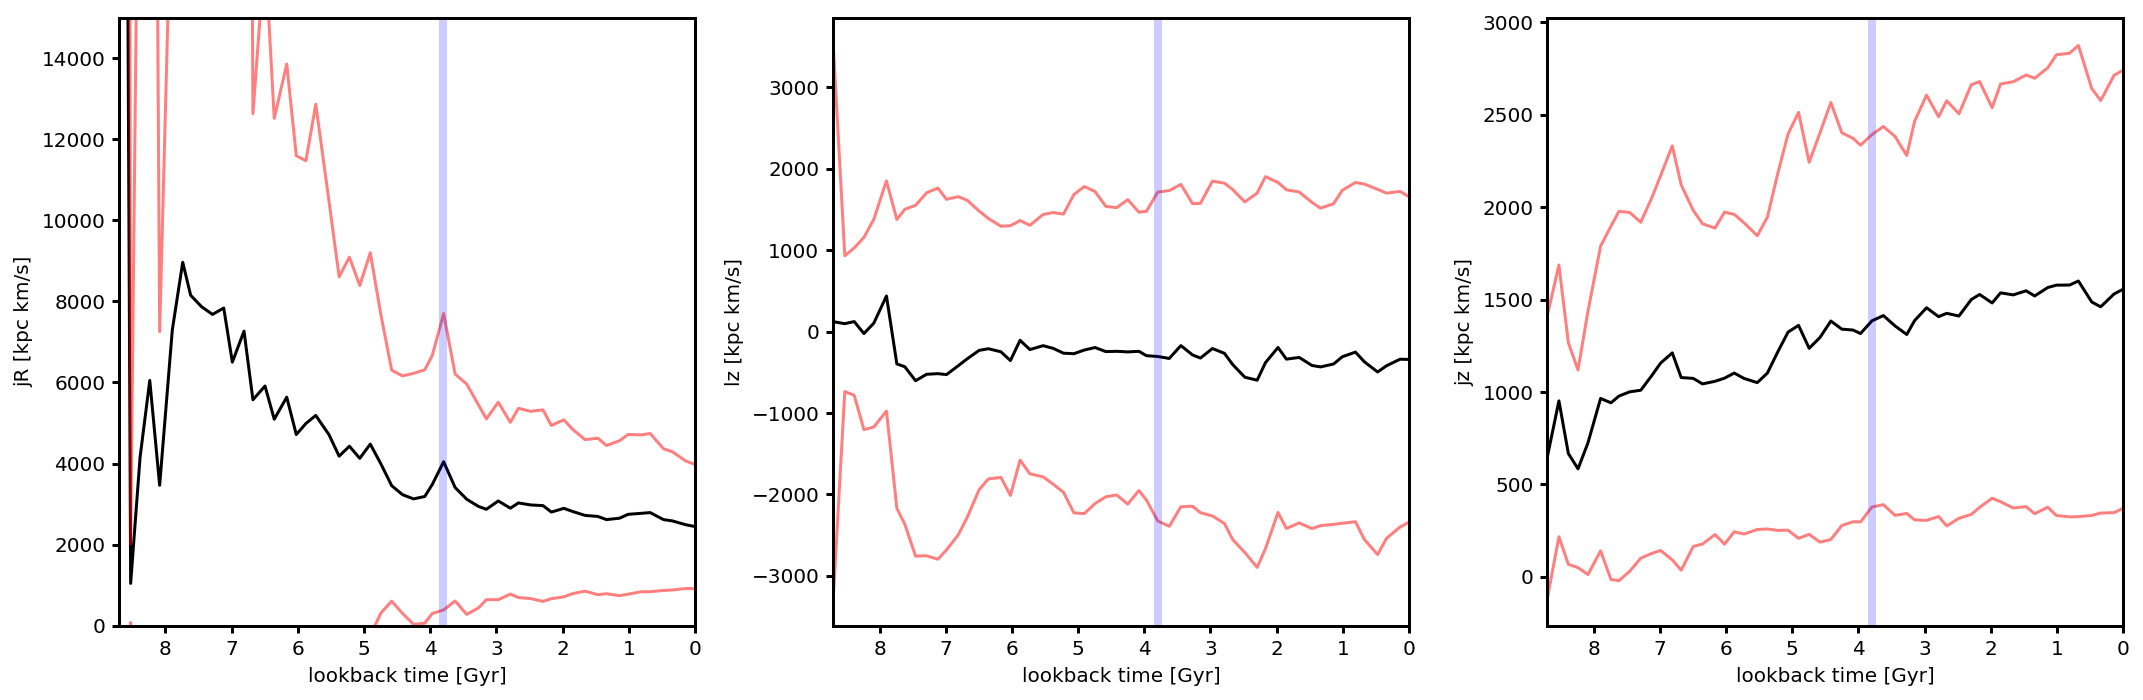

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(lookback_time_Gyr, jR_mean, 'k-')
ax[0].plot(lookback_time_Gyr, np.add(jR_mean, jR_std), 'r-', alpha = 0.5)
ax[0].plot(lookback_time_Gyr, np.subtract(jR_mean, jR_std), 'r-', alpha = 0.5)
ax[0].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
ax[0].set_ylim(0,15000)

ax[1].plot(lookback_time_Gyr, lz_mean, 'k-')
ax[1].plot(lookback_time_Gyr, np.add(lz_mean, lz_std), 'r-', alpha = 0.5)
ax[1].plot(lookback_time_Gyr, np.subtract(lz_mean, lz_std), 'r-', alpha = 0.5)
ax[1].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))

ax[2].plot(lookback_time_Gyr, jz_mean, 'k-')
ax[2].plot(lookback_time_Gyr, np.add(jz_mean, jz_std), 'r-', alpha = 0.5)
ax[2].plot(lookback_time_Gyr, np.subtract(jz_mean, jz_std), 'r-', alpha = 0.5)
ax[2].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
ax[0].set_ylim(0,None)

ax[0].set_xlabel('lookback time [Gyr]')
ax[1].set_xlabel('lookback time [Gyr]')
ax[2].set_xlabel('lookback time [Gyr]')


ax[0].set_ylabel('jR [kpc km/s]')
ax[1].set_ylabel('lz [kpc km/s]')
ax[2].set_ylabel('jz [kpc km/s]')
fig.tight_layout()

ax[0].axvline(3.8, color = 'blue', linewidth=4, alpha =0.2)
ax[1].axvline(3.8, color = 'blue', linewidth=4, alpha =0.2)
ax[2].axvline(3.8, color = 'blue', linewidth=4, alpha =0.2)


In [ ]:
#snapnrs = np.arange(startnr, endnr, 1)
#ivline = snapnrs.tolist().index(104)

In [ ]:
dim1 = len(lookback_time_Gyr)
jR_all_arr = np.array(jR_all)
jR_arr = np.array([])
for i in jR_all_arr[:,0].tolist():
    jR_arr = np.append(jR_arr, i.tolist())
jR_arr = jR_arr.reshape(dim1,20)

jz_all_arr = np.array(jz_all)
jz_arr = np.array([])
for i in jz_all_arr[:,0].tolist():
    jz_arr = np.append(jz_arr, i.tolist())
jz_arr = jz_arr.reshape(dim1,20)

lz_all_arr = np.array(lz_all)
lz_arr = np.array([])
for i in lz_all_arr[:,0].tolist():
    lz_arr = np.append(lz_arr, i.tolist())
lz_arr = lz_arr.reshape(dim1,20)

In [ ]:
jR_all[1][1][-1]


In [ ]:
x0 = np.max(lookback_time_Gyr)
x1 = np.min(lookback_time_Gyr)
xticks = np.around(np.linspace(x0,x1,6), 2)

yticks_jR = np.around(np.linspace(jR_all[1][1][0], jR_all[1][1][-1], 5),1)
yticks_jz = np.around(np.linspace(jz_all[1][1][0], jz_all[1][1][-1], 5),1)
yticks_lz = np.around(np.linspace(lz_all[1][1][0], lz_all[1][1][-1], 5),1)

In [ ]:
yticks_jR

In [ ]:
#print(jR_arr.reshape(20,55))

fig, ax = plt.subplots(1,3, figsize=(15,5))
im1 = ax[0].imshow(jR_arr.T, origin='lower',extent )
im2 = ax[1].imshow(lz_arr.T, origin='lower')
im3 = ax[2].imshow(jz_arr.T, origin='lower')
ax[0].set_xticks(np.linspace(0,dim1,6))
ax[0].set_xticklabels(xticks)
ax[1].set_xticks(np.linspace(0,dim1,6))
ax[1].set_xticklabels(xticks)
ax[2].set_xticks(np.linspace(0,dim1,6))
ax[2].set_xticklabels(xticks)
ax[0].set_xlabel('lookback time [Gyr]')
ax[1].set_xlabel('lookback time [Gyr]')
ax[2].set_xlabel('lookback time [Gyr]')

ax[0].set_yticks(np.linspace(0,20,5))
ax[0].set_yticklabels(yticks_jR)
ax[1].set_yticks(np.linspace(0,20,5))
ax[1].set_yticklabels(yticks_lz)
ax[2].set_yticks(np.linspace(0,20,5))
ax[2].set_yticklabels(yticks_jz)
#
#ax[0].plot(jR_mean, 'k-')
#ax[0].plot(np.add(jR_mean, jR_std), 'r-', alpha = 0.5)
#ax[0].plot(np.subtract(jR_mean, jR_std), 'r-', alpha = 0.5)
#ax[0].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
#ax[0].set_ylim(0,15000)

#ax[1].plot(lz_mean, 'k-')
#ax[1].plot(np.add(lz_mean, lz_std), 'r-', alpha = 0.5)
#ax[1].plot(np.subtract(lz_mean, lz_std), 'r-', alpha = 0.5)
#ax[1].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))

#ax[2].plot(jz_mean, 'k-')
#ax[2].plot(np.add(jz_mean, jz_std), 'r-', alpha = 0.5)
#ax[2].plot(np.subtract(jz_mean, jz_std), 'r-', alpha = 0.5)
'''

ax[0].plot(lookback_time_Gyr, jR_mean, 'k-')
ax[0].plot(lookback_time_Gyr, np.add(jR_mean, jR_std), 'r-', alpha = 0.5)
ax[0].plot(lookback_time_Gyr, np.subtract(jR_mean, jR_std), 'r-', alpha = 0.5)
#ax[0].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
#ax[0].set_ylim(0,15000)

ax[1].plot(lookback_time_Gyr, lz_mean, 'k-')
ax[1].plot(lookback_time_Gyr, np.add(lz_mean, lz_std), 'r-', alpha = 0.5)
ax[1].plot(lookback_time_Gyr, np.subtract(lz_mean, lz_std), 'r-', alpha = 0.5)
#ax[1].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))

ax[2].plot(lookback_time_Gyr, jz_mean, 'k-')
ax[2].plot(lookback_time_Gyr, np.add(jz_mean, jz_std), 'r-', alpha = 0.5)
ax[2].plot(lookback_time_Gyr, np.subtract(jz_mean, jz_std), 'r-', alpha = 0.5)'''
#ax[2].set_xlim(np.max(lookback_time_Gyr), np.min(lookback_time_Gyr))
ax[0].set_ylim(0,None)

ax[0].set_ylabel('jR [kpc km/s]')
ax[1].set_ylabel('lz [kpc km/s]')
ax[2].set_ylabel('jz [kpc km/s]')
fig.tight_layout()

#ax[0].axvline(jR_mean, color = 'red', linewidth=4, alpha =0.2)
#ax[1].axvline(ivline, color = 'red', linewidth=4, alpha =0.2)
#ax[2].axvline(ivline, color = 'red', linewidth=4, alpha =0.2)


In [ ]:
fig.savefig(plotdir + 'action_mean_time_evolution_merger_73.png', dpi = 300, format = 'png')